<html>
<head>

<h1 style="color:red; font-size:30px; font-style:italic; font-alignment:center;">Title: Image Captioning using Deep Learning</h1>
<br><br>
<h1 style="color:black; font-style:italic; font-size:24px">Table of Contents</h1>
<br>
<ol>
    <li style='color:green; font-style:italic; font-size:20px'>Objective/Goal and Business Questions</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>Introduction</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>About Data</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>Evaluation Metrics</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>Load Captions and Pre-process</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>Feature Extraction From Images</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>Model Training</li><br><br>
    <li style='color:green; font-style:italic; font-size:20px'>Conclusion</li><br><br>
</ol>


<br>
<h1 style='color:black; font-style:italic; font-size:25px'>7.&nbsp;&nbsp;Model Training</h1><br>
<ol>
<li style='color:green; font-style:italic; font-size:17px'>Loading extracted features and pre-preocessed captions</li><br>
<li style='color:green; font-style:italic; font-size:17px'>Tokenization</li><br>
<li style='color:green; font-style:italic; font-size:17px'>Custom Dataloader</li><br>
<li style='color:green; font-style:italic; font-size:17px'>Model Definition and Initialisation</li><br>
<li style='color:green; font-style:italic; font-size:17px'>Model training</li><br>
<li style='color:green; font-style:italic; font-size:17px'>Prediction and Model Evaluation</li><br>
<li style='color:green; font-style:italic; font-size:17px'>Model training</li><br>
</ol>


**What we have done till now...**

1. We have pre-processed image captions for both train and val set
2. Extracted features from train, val and test set images and saved them to the disk

**Importing dependencies**

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import pickle as pkl

import gc
from PIL import Image

from tensorflow.keras.layers import Input, Embedding, RepeatVector, TimeDistributed, LSTM, Dense, Dropout, Concatenate, GRU
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow import expand_dims
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences



root_dir = "D:\\projects\\image-captioning"
shape = (600, 600, 3)
size = (600, 600)
max_length = 27

<h1 style='color:black; font-style:italic; font-size:20px'>7.1&nbsp;Loading extracted features and pre-preocessed captions</h1>

In [2]:
captions_path = glob.glob(os.path.join(root_dir, "*_captions_list.pkl"))
features_path = glob.glob(os.path.join(root_dir, "*_b7.pkl"))

captions_path, features_path

(['D:\\projects\\image-captioning\\train_captions_list.pkl',
  'D:\\projects\\image-captioning\\val_captions_list.pkl'],
 ['D:\\projects\\image-captioning\\test_features_eff_b7.pkl',
  'D:\\projects\\image-captioning\\train_features_eff_b7.pkl',
  'D:\\projects\\image-captioning\\val_features_eff_b7.pkl'])

In [3]:
def load_preprocessed_captions(path, name):
    print(f"Loading preprocessed {name} captions...", end='')
    with open(path, 'rb') as f:
        captions = pkl.load(f)
    print("done!")
    return captions

def load_extracted_features(path, name):
    print(f"Loading extracted {name} features...", end='')
    with open(path, 'rb') as f:
        features = pkl.load(f)
    print("done!")
    return features

In [4]:
val_captions = load_preprocessed_captions(captions_path[1], 'val')
val_features = load_extracted_features(features_path[2], 'val')

Loading preprocessed val captions...done!
Loading extracted val features...done!


In [5]:
train_captions = load_preprocessed_captions(captions_path[0], 'train')
train_features = load_extracted_features(features_path[1], 'train')

Loading preprocessed train captions...done!
Loading extracted train features...done!


In [6]:
test_features = load_extracted_features(features_path[0], 'test')

Loading extracted test features...done!


<h1 style='color:black; font-style:italic; font-size:20px'>7.2&nbsp;Tokenization</h1>

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token_path = os.path.join(root_dir, 'tokenizer_21_nov_2022.pkl')

if os.path.isfile(token_path):

    print(f"Loading tokenizer from location {token_path} ...", end='')
    with open(token_path, 'rb') as f:
        tokenizer = pkl.load(f)
    print("done!")

else:
    texts = ''
    for cap_list in tqdm(train_captions.values()):
        for cap in cap_list:
            texts += ' ' + cap
            
    tokenizer = Tokenizer(filters='')

    tokenizer.fit_on_texts([texts])
    
    print(f"Saving tokenizer to location {token_path} ...", end='')
    with open(token_path, 'wb') as f:
        pkl.dump(tokenizer, f)
    print("done!")
    
    del texts

Loading tokenizer from location D:\projects\image-captioning\tokenizer_21_nov_2022.pkl ...done!


In [8]:
vocabulary = tokenizer.word_index
inverse_vocabulary = tokenizer.index_word

vocab_size = len(vocabulary) + 1

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 26416


<h1 style='color:black; font-style:italic; font-size:20px'>7.3&nbsp;Custom Dataloader</h1>

In [9]:
train_images_name = list(train_features.keys())
val_images_name = list(val_features.keys())
test_images_name = list(test_features.keys())

* Custom datagenerator for model training

In [10]:
from tensorflow.keras.utils import to_categorical
import gc
import random


def dataloader(image_names, features, captions, batch_size):
    n=1
    l=len(features)
    
    inp_feature, inp_caption, out_caption = [], [], []
    
    random.shuffle(image_names)
    
    while True:
        for img_name in image_names:
            n += 1
            feat = features[img_name]
            caption_list = captions[img_name]
            
            for capt in caption_list:
                seq = tokenizer.texts_to_sequences([capt])[0]
                for i in range(len(seq)):
                    x = seq[:i]
                    y = seq[i]

                    x = pad_sequences([x], maxlen=max_length, padding='post')[0]
                    y = to_categorical(y, num_classes=vocab_size)

                    inp_feature.append(feat)
                    inp_caption.append(x)
                    out_caption.append(y)

            if n%batch_size==0 or batch_size==l:
                inp_feature, inp_caption, out_caption = np.array(inp_feature), np.array(inp_caption), np.array(out_caption)
                yield [inp_feature, inp_caption], out_caption
                del inp_feature
                del inp_caption
                del out_caption
                inp_feature, inp_caption, out_caption = [], [], []
        gc.collect()

<h1 style='color:black; font-style:italic; font-size:20px'>7.4&nbsp;Model Definition and Initialisation</h1>

In [11]:
def build_seq2seq_model(feature_input_shape=2560, rate=0.5, lstm_units=256, vocab_size=vocab_size, embedding_dim=100, max_length=max_length):
    tf.keras.backend.clear_session()
    input_1 = Input(shape=(feature_input_shape,), name='input_1_layer')
    x1 = Dense(embedding_dim, activation='relu', name='input_1_dense_1_layer')(input_1)
    x1 = Dropout(rate, name='input_1_dropout_layer')(x1)
    x1 = RepeatVector(max_length, name='repeat_vector_layer')(x1)

    input_2 = Input(shape=(max_length,), name='input_2_layer')
    x2 = Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero=True, name='embedding_layer_1')(input_2)
    x2, state = GRU(lstm_units, return_state=True, return_sequences=True, name='input_2_layer_LSTM_1',)(x2)
    x2, state = GRU(lstm_units, return_state=True, return_sequences=True, name='input_2_layer_LSTM_2',)(x2, initial_state=[state])

    x2 = TimeDistributed(Dense(lstm_units, activation='softmax', name='dec_time_distributed_layer'), name='time_dsitributed_layer')(x2)
    x = Concatenate()([x1,x2])  

    x = GRU(lstm_units, return_sequences=False, name='decoder_layer_LSTM_3',)(x, initial_state=[state])
    
    x = Dense(2048, activation='relu', name='hidden_layer_1')(x)
    x = Dropout(rate, name='decoder_dropout_layer')(x)

    output = Dense(vocab_size, activation='softmax', name='dec_output_layer')(x)
    model = Model(inputs=[input_1, input_2], outputs=output, name='seq2seq_model')

    return model

* Initialising our model that will be trained on images and captions

In [12]:
EMBEDDING_DIM = 100
model = build_seq2seq_model(embedding_dim=EMBEDDING_DIM)
model.summary()

Model: "seq2seq_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2_layer (InputLayer)      [(None, 27)]         0                                            
__________________________________________________________________________________________________
input_1_layer (InputLayer)      [(None, 2560)]       0                                            
__________________________________________________________________________________________________
embedding_layer_1 (Embedding)   (None, 27, 100)      2641600     input_2_layer[0][0]              
__________________________________________________________________________________________________
input_1_dense_1_layer (Dense)   (None, 100)          256100      input_1_layer[0][0]              
______________________________________________________________________________________

* Calculating train and val steps, they will be used later in training of model

* Defining optimizer, compiling model and Initialing custom model checkpoint callback to save best model during training

In [13]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
opt = Adam(learning_rate=0.001)

In [14]:
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = os.path.join(root_dir, 'trained-model', 'model_21_nov_2022.h5')
ckpnt = ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True, verbose=1)
es = EarlyStopping(patience=1, min_delta=0.1, verbose=1, restore_best_weights=True)

* Fitting model on train data

In [17]:
batch_size = 8
val_dataloader = dataloader(val_images_name, val_features, val_captions, batch_size)
train_dataloader = dataloader(train_images_name[:80000], train_features, train_captions, batch_size)

In [18]:
for i in val_dataloader:
    print(i[0][0].shape)
    print(i[0][1].shape)
    print(i[1].shape)
    break

(361, 2560)
(361, 27)
(361, 26416)


<h1 style='color:black; font-style:italic; font-size:20px'>7.5&nbsp;Model Training</h1>

* Training our model only on 80k images, since it is huge dataset it will take large amount of training time
* and validating on all 5k images

In [20]:
train_steps = len(train_images_name[:80000])//batch_size + 1
val_steps = len(val_images_name)//batch_size + 1

In [21]:
model.fit(train_dataloader, 
          steps_per_epoch=train_steps, 
          epochs=5, 
          validation_data=val_dataloader, 
          validation_steps=val_steps, 
          callbacks=[ckpnt, es])

Epoch 1/5
10001/10001 [==============================] - 6790s 678ms/step - loss: 3.4416 - val_loss: 2.9257

Epoch 00001: val_loss improved from inf to 2.92572, saving model to D:\projects\image-captioning\trained-model\model_21_nov_2022.h5
Epoch 2/5
10001/10001 [==============================] - 6796s 680ms/step - loss: 2.9721 - val_loss: 2.7916

Epoch 00002: val_loss improved from 2.92572 to 2.79160, saving model to D:\projects\image-captioning\trained-model\model_21_nov_2022.h5
Epoch 3/5
10001/10001 [==============================] - 6790s 679ms/step - loss: 2.8453 - val_loss: 2.7411

Epoch 00003: val_loss improved from 2.79160 to 2.74109, saving model to D:\projects\image-captioning\trained-model\model_21_nov_2022.h5
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


* Since dataset is huge, our model took nearly 2 hr in training per epoch

<h1 style='color:black; font-style:italic; font-size:20px'>7.6&nbsp;Prediction and Model Evaluation</h1>

* Generating Caption/Text From extracted features

In [26]:
def generate_caption(feature, model):
    text = '<sos>' # text with <sos> token only for prediction
    feature = feature.reshape(1,2560) # reshaping feature for model input
    for i in range(max_length): # for loop through the max length
        seq = tokenizer.texts_to_sequences([text]) # converting text to sequences
        seq = pad_sequences(seq, maxlen=max_length, padding='post') # padding text sequences
        yhat = model.predict([feature, seq]) # predicting next word using trained-model
        yhat = np.argmax(yhat) # getting argmax of predicted word, which will be further used get word from inverse vocabulary
        
        word = tokenizer.index_word.get(yhat) # getting predicted word
        
        text += ' ' + word # adding predicted word to the sentence
        
        if word == '<eos>': # if <eos> found it means prediction completed and break the prediction loop for currrent feature/image
            break
            
    return text # return predicted text

* Function to show and read images from disk

In [65]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(name, img_type, title=None):
    # Getting path of images for dartaset type
    if img_type == 'train':
        path = "D:/MS-COCO-2017-dataset/coco2017/train2017/" + name
    if img_type == 'val': 
        path = "D:/MS-COCO-2017-dataset/coco2017/val2017/" + name
    if img_type == 'test':
        path = "D:/MS-COCO-2017-dataset/coco2017/test2017/" + name
        
    img = Image.open(path) # Reading image from disk
    img = img.resize(size)
    plt.figure(figsize=(3,7)) # Ploting figure to show loaded image
    plt.imshow(img) # ploting image using matplotlib
    if title: # if title given 
        plt.title(title)
        
    plt.axis('off') # setting axis off for image plot
    plt.show()

Generated caption: <sos> man is playing tennis on the court <eos>


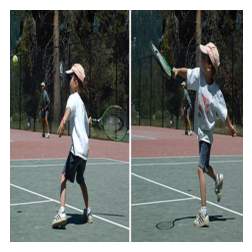

************************************************************************************************************************

Generated caption: <sos> man is sitting at table with glass of wine <eos>


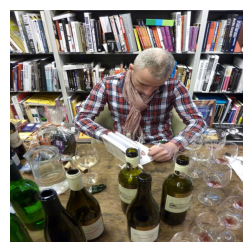

************************************************************************************************************************

Generated caption: <sos> man riding motorcycle down street next to building <eos>


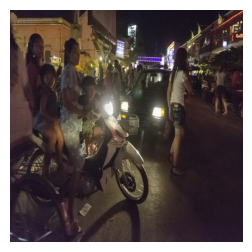

************************************************************************************************************************

Generated caption: <sos> man riding skateboard down the side of ramp <eos>


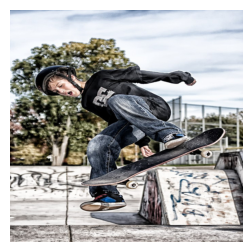

************************************************************************************************************************

Generated caption: <sos> group of people playing frisbee in field <eos>


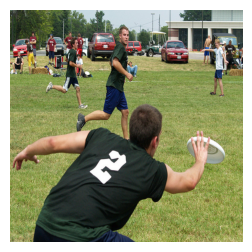

************************************************************************************************************************



In [66]:
for img_name in test_images_name[:5]:  
    # Generating caption from test image features 
    caption = generate_caption(test_features[img_name], model)
    # printing generated caption and showing images
    print(f"Generated caption: {caption}")
    show_image(img_name, 'test')
    print('*'*120)
    print('')

* Function to calculate BLEU score using pre-trained model

In [29]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tqdm import tqdm

def calculate_bleu_score(images_names, captions, features, num_samples=10):
    bleu_score = 0
    for img_name in tqdm(images_names[:num_samples]): # for each image in sample images
        predicted_caption = generate_caption(features[img_name], model)[6:-6] # clipping <sos> and <eos> from predicted caption
        predicted_caption = predicted_caption.split() # tokenizing predicted caption
        original_captions_list = captions[img_name] # getting original caption from dictionary
        reference_corpus = [] # empty list to store tokenized original captions
        for original_caption in original_captions_list: # for each caption in caption list for an image
            original_caption = original_caption[6:-6] # clipping <sos> and <eos> from original caption
            original_caption = original_caption.split() # tokenizing original caption
            reference_corpus.append(original_caption) # storing tokenized original caption into list
        # passing tokenised reference_corpus list and tokenized predicted_captions to corpus bleu
        score = corpus_bleu([reference_corpus], [predicted_caption], weights=[1])
        bleu_score += score # adding score to bleu score
            
    return bleu_score/num_samples # returning average of bleu score for all the captions

* Calculating BLEU score for train images

In [30]:
train_score = calculate_bleu_score(train_images_name, train_captions, train_features, 10_000)

print(f"Bleu score on train data is: {train_score}")

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:16:26<00:00,  2.18it/s]

Bleu score on train data is: 0.564013811713352


* Calculating BLEU score for val images

In [31]:
val_score = calculate_bleu_score(val_images_name, val_captions, val_features, 5_000)

print(f"Bleu score on val data is: {val_score}")

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [38:13<00:00,  2.18it/s]

Bleu score on val data is: 0.5577559169122197


<h1 style='color:black; font-style:italic; font-size:30px'>8.&nbsp;Conclusion</h1>

<p style='color:green; font-style:italic; font-size:17px;'>
1.&nbsp;Since, we trained our model and can conclude by considering above BLEU score for train and val captions that our model is good enough because BLEU score is 55.77%.
</p>
<p style='color:green; font-style:italic; font-size:17px;'>
2.&nbsp;Our model is generalised model, because there is very less difference between the train and val BLEU score and our model is doing great job on val images data.
</p>
<p style='color:green; font-style:italic; font-size:17px;'>
3.&nbsp;After this, we need to generate captions for test images and observe.
</p>

#### Let's generate text/caption on test image data.

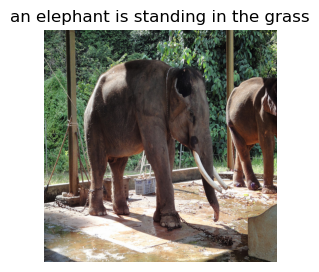

************************************************************************************************************************



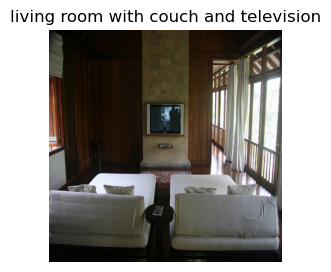

************************************************************************************************************************



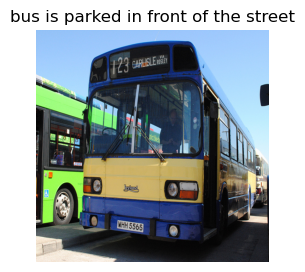

************************************************************************************************************************



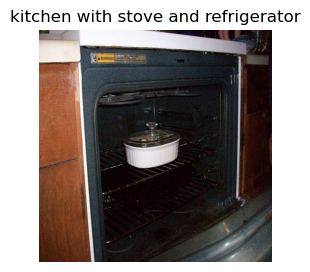

************************************************************************************************************************



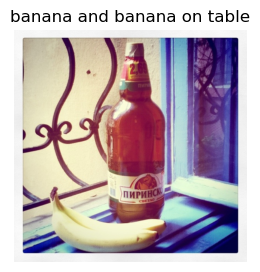

************************************************************************************************************************



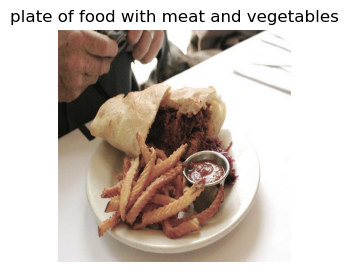

************************************************************************************************************************



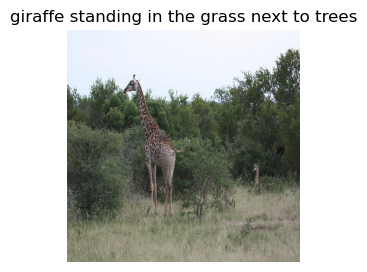

************************************************************************************************************************



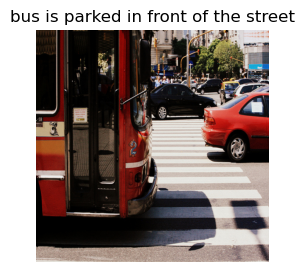

************************************************************************************************************************



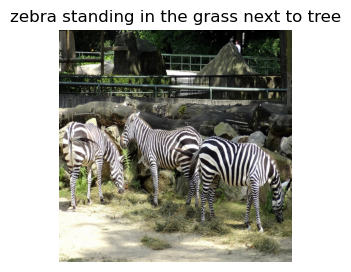

************************************************************************************************************************



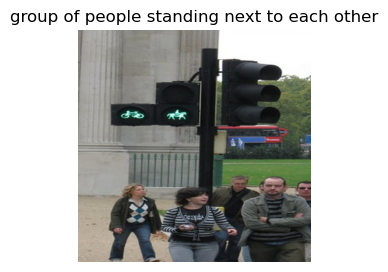

************************************************************************************************************************



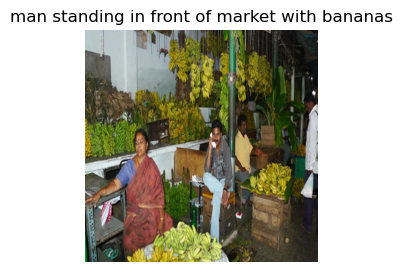

************************************************************************************************************************



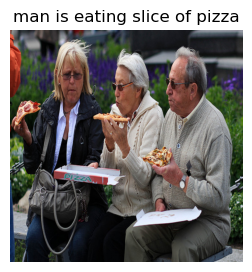

************************************************************************************************************************



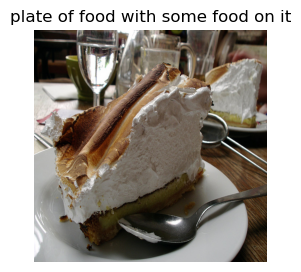

************************************************************************************************************************



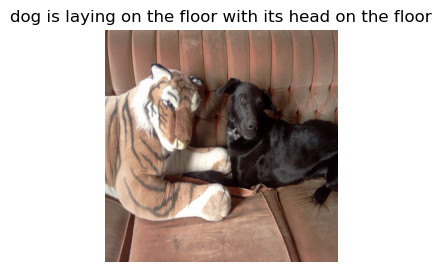

************************************************************************************************************************



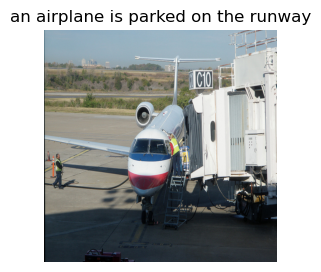

************************************************************************************************************************



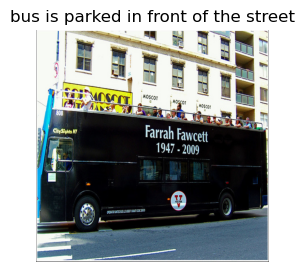

************************************************************************************************************************



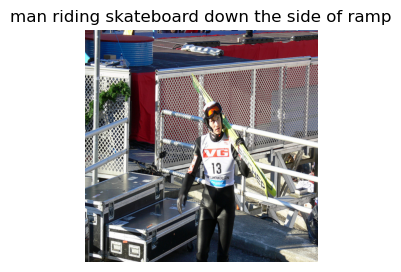

************************************************************************************************************************



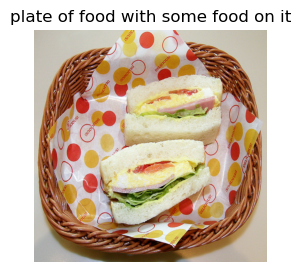

************************************************************************************************************************



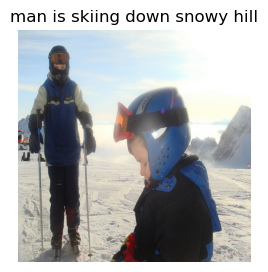

************************************************************************************************************************



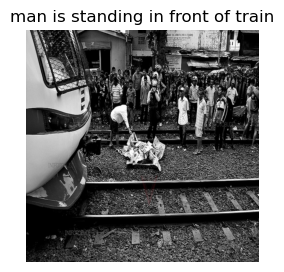

************************************************************************************************************************



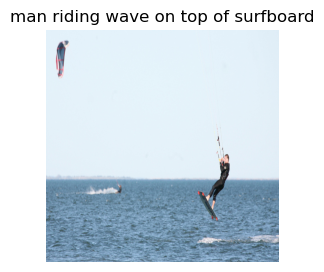

************************************************************************************************************************



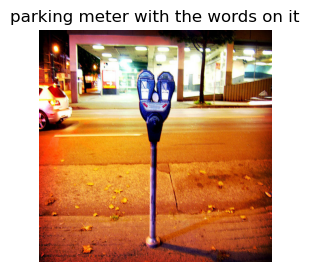

************************************************************************************************************************



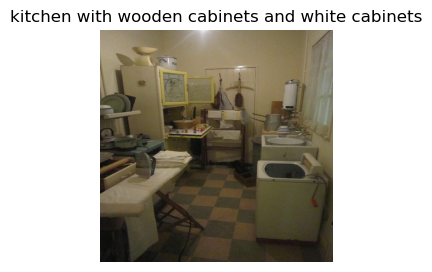

************************************************************************************************************************



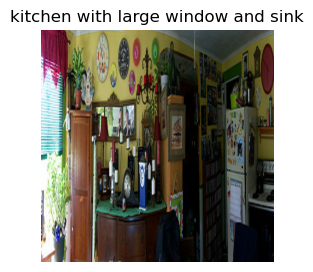

************************************************************************************************************************



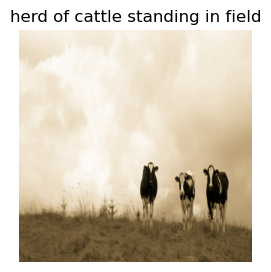

************************************************************************************************************************



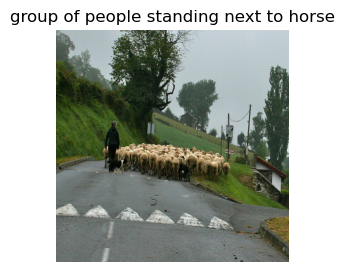

************************************************************************************************************************



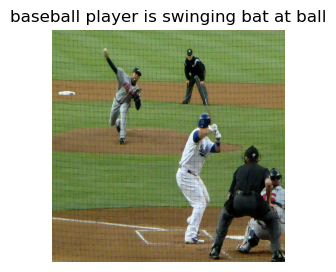

************************************************************************************************************************



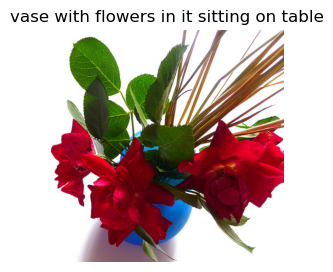

************************************************************************************************************************



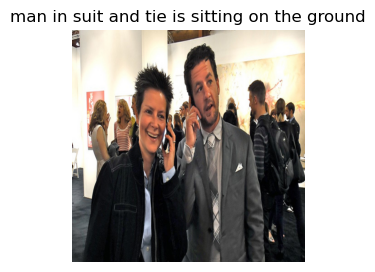

************************************************************************************************************************



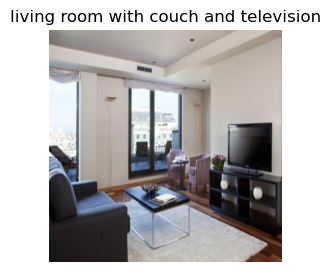

************************************************************************************************************************



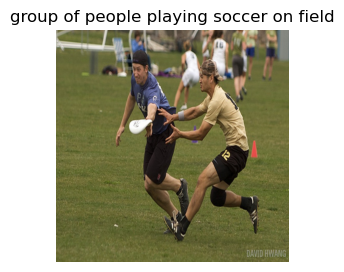

************************************************************************************************************************



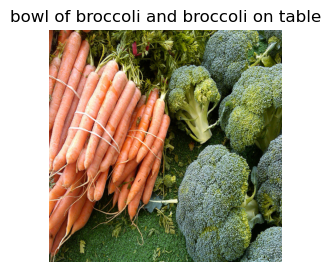

************************************************************************************************************************



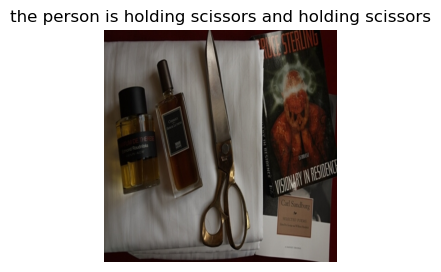

************************************************************************************************************************



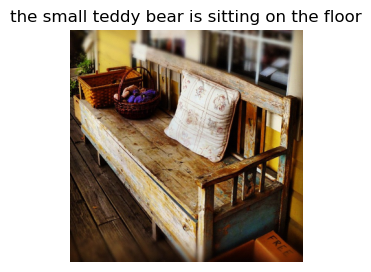

************************************************************************************************************************



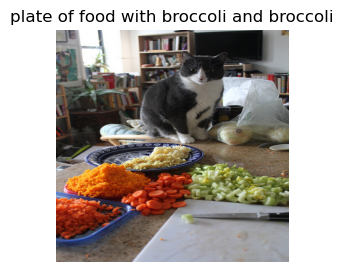

************************************************************************************************************************



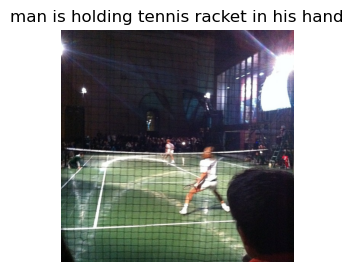

************************************************************************************************************************



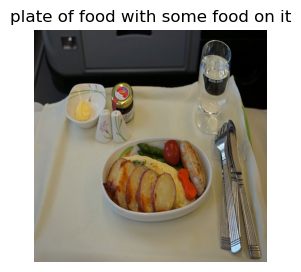

************************************************************************************************************************



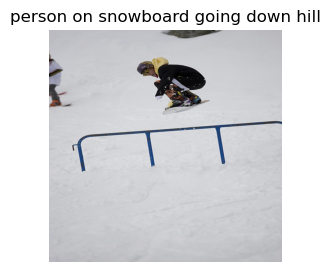

************************************************************************************************************************



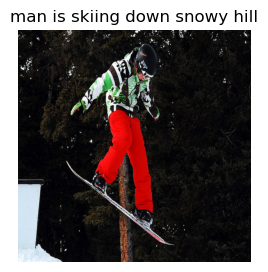

************************************************************************************************************************



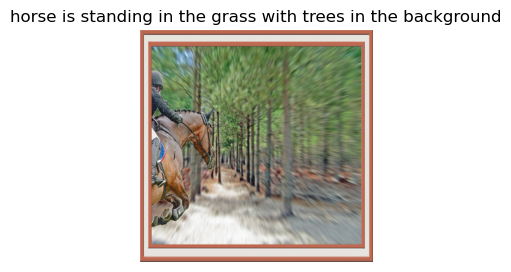

************************************************************************************************************************



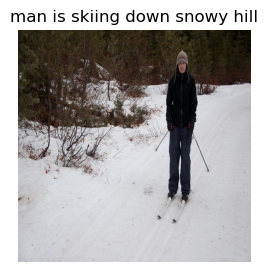

************************************************************************************************************************



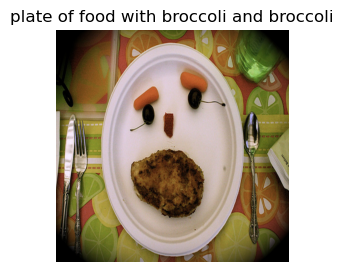

************************************************************************************************************************



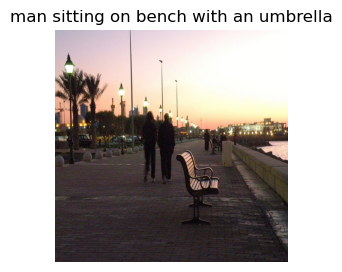

************************************************************************************************************************



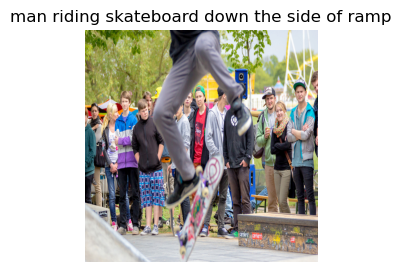

************************************************************************************************************************



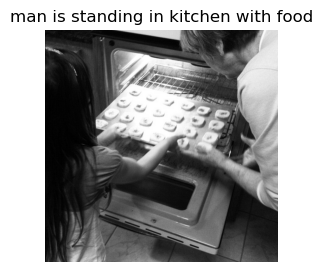

************************************************************************************************************************



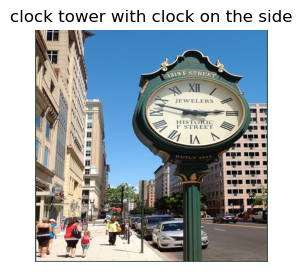

************************************************************************************************************************



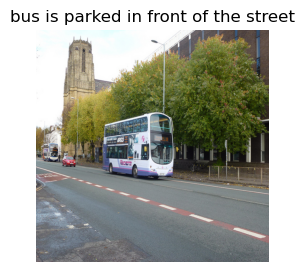

************************************************************************************************************************



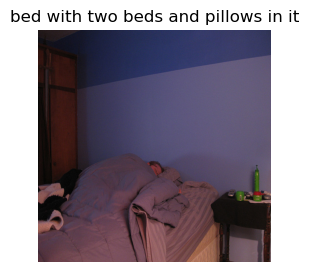

************************************************************************************************************************



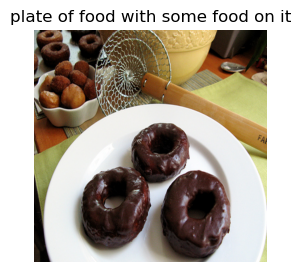

************************************************************************************************************************



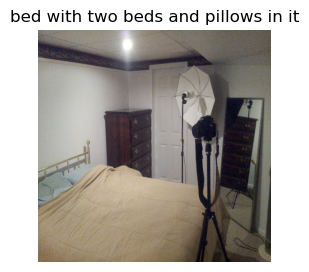

************************************************************************************************************************



In [67]:
random.shuffle(test_images_name) # shuffling train image names
for img_name in test_images_name[:50]:  
    # Generating caption from test image features 
    caption = generate_caption(test_features[img_name], model)[6:-6]
    # showing images with generated caption as title
    show_image(img_name, 'test', caption)
    print('*'*120)
    print('')

* From above generated text, we can see that our model is predicting/generating text fairly well on test data.